In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from my_utils import plot_image, load_model, process_frame_and_annotate, live_camera
import cv2
%matplotlib inline

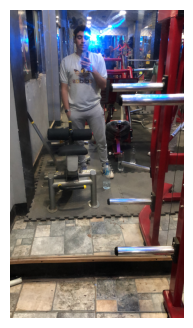

In [3]:
frame = cv2.imread('1.jpeg')
plot_image(frame, 4)

In [4]:
POSE_MODEL_WEIGHTS_PATH = "yolov7-w6-pose.pt"
pose_model = load_model(POSE_MODEL_WEIGHTS_PATH)

/home/moaz/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


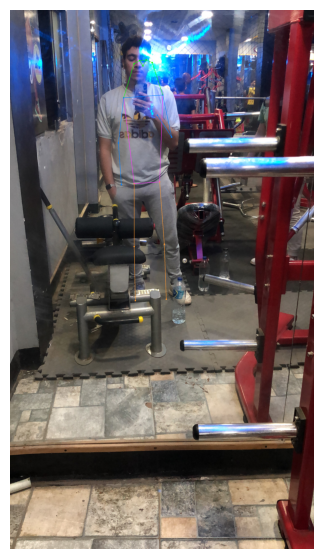

In [5]:
annoted_frame = process_frame_and_annotate(pose_model, frame)
plot_image(annoted_frame, 7)

In [6]:
from functools import partial

annotator = partial(process_frame_and_annotate, pose_model)

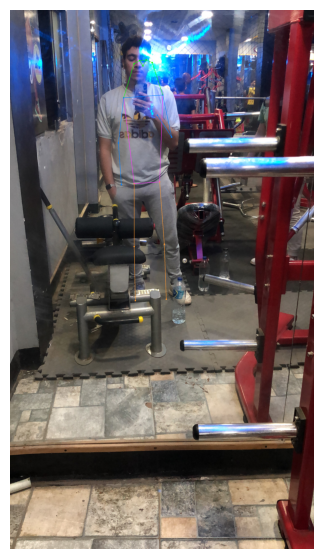

In [7]:
annotated = annotator(frame)
plot_image(annotated, 7)

In [8]:
live_camera(annotator)

### Getting joints and angels 

In [9]:
from my_utils import pose_pre_process_frame, pose_post_process_output, pose_annotate
import torch

POSE_IMAGE_SIZE = 256
STRIDE = 64
CONFIDENCE_THRESHOLD = 0.25
IOU_THRESHOLD = 0.65

In [63]:
frame = cv2.imread('1.jpeg')

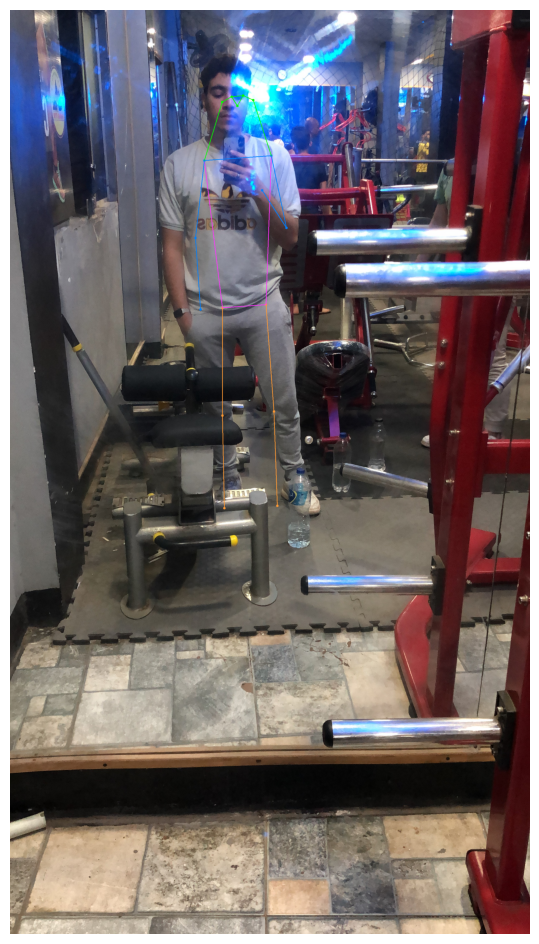

In [64]:
pose_pre_processed_frame = pose_pre_process_frame(frame=frame.copy())

image_size = frame.shape[:2]
scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

with torch.no_grad():
    pose_output, _ = pose_model(pose_pre_processed_frame)
    pose_output = pose_post_process_output(
        model=pose_model,
        output=pose_output,
        confidence_threshold=CONFIDENCE_THRESHOLD,
        iou_threshold=IOU_THRESHOLD,
        image_size=image_size,
        scaled_image_size=scaled_image_size
    )

annotated_frame = pose_annotate(image=frame, detections=pose_output)
plot_image(annotated_frame)

In [65]:
pose_output[0]

array([          0,           0,        85.5,      71.766,      40.844,      114.38,     0.78806,       944.3,      398.91,     0.87012,      968.91,      355.78,     0.87695,      920.39,      360.94,     0.81885,      1010.4,      374.06,     0.62012,      881.02,      382.03,     0.56738,      1085.6,      605.62,
           0.96533,      807.19,      625.78,     0.96045,      1148.9,      905.16,     0.89795,      770.62,      947.34,       0.875,      1047.7,      749.53,     0.84766,      791.02,      1244.1,     0.81982,      1063.1,      1224.4,     0.95068,      882.42,      1237.5,     0.94629,      1096.9,      1668.8,
           0.82568,      882.42,      1685.6,     0.81396,      1110.9,      2060.6,     0.60889,      890.16,        2070,     0.59521])

In [66]:
pose_output.shape

(1, 58)

In [67]:
len(pose_output[0, 7:]) / 3

17.0

In [68]:
kpts = pose_output[0, 7:].T; kpts

array([      944.3,      398.91,     0.87012,      968.91,      355.78,     0.87695,      920.39,      360.94,     0.81885,      1010.4,      374.06,     0.62012,      881.02,      382.03,     0.56738,      1085.6,      605.62,     0.96533,      807.19,      625.78,     0.96045,      1148.9,      905.16,     0.89795,
            770.62,      947.34,       0.875,      1047.7,      749.53,     0.84766,      791.02,      1244.1,     0.81982,      1063.1,      1224.4,     0.95068,      882.42,      1237.5,     0.94629,      1096.9,      1668.8,     0.82568,      882.42,      1685.6,     0.81396,      1110.9,      2060.6,     0.60889,
            890.16,        2070,     0.59521])

In [69]:
coord = []
no_kpt = len(kpts)//3
for i in range(no_kpt):
    cx_cy = kpts[3*i], kpts[3*i + 1]
    conf = kpts[3*i + 2]
    coord.append([i, cx_cy, conf])

In [70]:
coord

[[0, (944.296875, 398.90625), 0.8701171875],
 [1, (968.90625, 355.78125), 0.876953125],
 [2, (920.390625, 360.9375), 0.81884765625],
 [3, (1010.390625, 374.0625), 0.6201171875],
 [4, (881.015625, 382.03125), 0.5673828125],
 [5, (1085.625, 605.625), 0.96533203125],
 [6, (807.1875, 625.78125), 0.96044921875],
 [7, (1148.90625, 905.15625), 0.89794921875],
 [8, (770.625, 947.34375), 0.875],
 [9, (1047.65625, 749.53125), 0.84765625],
 [10, (791.015625, 1244.0625), 0.81982421875],
 [11, (1063.125, 1224.375), 0.95068359375],
 [12, (882.421875, 1237.5), 0.9462890625],
 [13, (1096.875, 1668.75), 0.82568359375],
 [14, (882.421875, 1685.625), 0.81396484375],
 [15, (1110.9375, 2060.625), 0.60888671875],
 [16, (890.15625, 2070.0), 0.59521484375]]

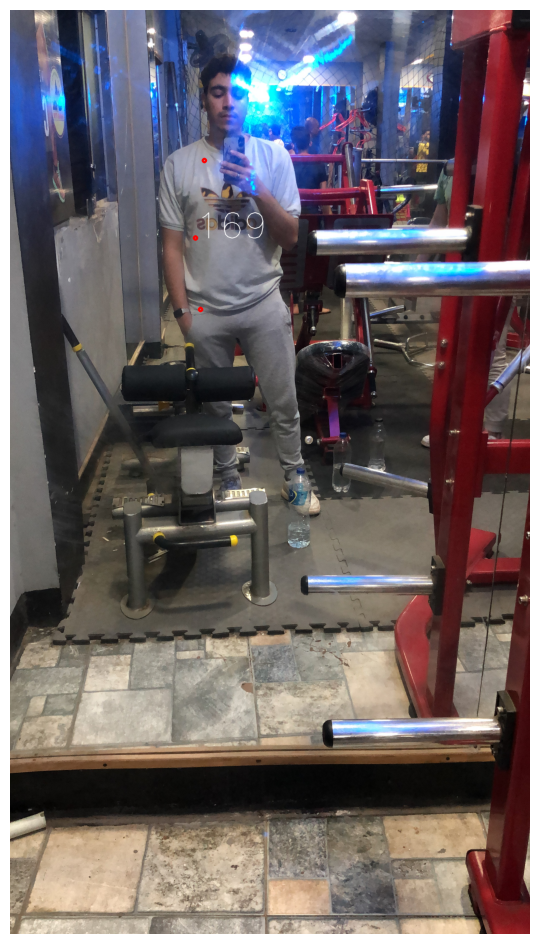

In [100]:
frame = cv2.imread('1.jpeg')

# selected = [coord[5], coord[7], coord[9]]
selected = [coord[6], coord[8], coord[10]]
elbow = int(selected[1][1][0]), int(selected[1][1][1])
angle = calculate_angle(np.array(selected[0][1]), np.array(selected[1][1]), np.array(selected[2][1]))
for point in selected:
    if point[2] > .5:
        frame = cv2.circle(frame, (int(point[1][0]), int(point[1][1])), radius=7, color=(0, 0, 255), thickness=7)
    
cv2.putText(frame, str(int(angle)), elbow,cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 2, cv2.LINE_AA)
plot_image(frame)

In [77]:
import numpy as np

In [88]:
def calculate_angle(a: np.ndarray, b: np.ndarray, c: np.ndarray) -> float:
    ba = a - b
    bc = c - b
    
    cosine_angel = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angel)
    return np.degrees(angle)

In [89]:
selected

[[6, (807.1875, 625.78125), 0.96044921875],
 [8, (770.625, 947.34375), 0.875],
 [10, (791.015625, 1244.0625), 0.81982421875]]

In [91]:
selected = [coord[6], coord[8], coord[10]]
calculate_angle(np.array(selected[0][1]), np.array(selected[1][1]), np.array(selected[2][1]))

169.58197119744824

In [93]:
selected[1][1]

(770.625, 947.34375)

In [101]:
from my_utils import calculate_angle

21.118802692736928


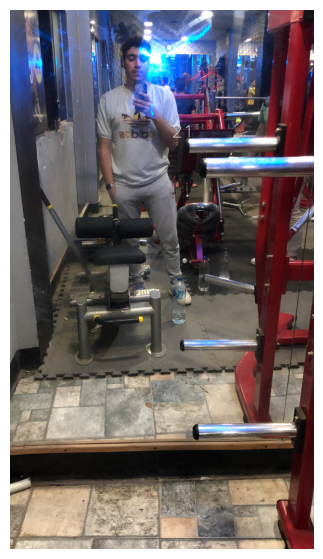

In [108]:
frame = cv2.imread('1.jpeg')
left_arm = [6, 8, 10]
right_arm = [5, 7 ,9]
angle = calculate_angle(kpts, *right_arm, draw=True, frame = frame)
print(angle)
plot_image(frame, size=7)